In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.style as style
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline
import fittes as fts

from data_manager import DataManager
import transport_signal_processing as tsp

In [2]:
# parameters
path = "*_K238A_25C_100mV_ChyS1*"


#parameters gauss fit
lxlims_on = (0, 40)
lbins_on = 80

key_sel = "id"
re_sel = ""
level = 1
selected_only = True

fsz = 18

In [3]:
# setup database connector
sigman = DataManager('database')

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l)
# keep only key in dataframe and signal info
df = df[df[key_sel].str.match(re_sel) & (df['selected'] > (level-1))]
sinfo_l = [sinfo_l[i] for i in df.index.values]
df = df.reset_index(drop=True)

# set unique instance id
df['iid'] = np.unique(df[key_sel], return_inverse=True)[1]
display(df)

# debug print
key_sels = np.unique(df[key_sel].values)

# load statistics of all events
ids = []
stats = []
for i in range(len(sinfo_l)):
    sinfo = sinfo_l[i]
    curr_path = sigman.define_db_path(sinfo)
    
    s_l = sigman.load_data(curr_path, 's{}-stats'.format(sinfo['sid']))
    if len(s_l) > 0:
        s = s_l[0]
        m = sigman.load_data(curr_path, 's{}-selected'.format(sinfo['sid']))[0].astype(bool)
        if selected_only:
            s = s[m]

        ids.append(df['iid'].values[i] * np.ones(s.shape[0], dtype=int))
        # rescale mean and standard deviation based on open pore stats
        s[:,1] = 100.0 * s[:,1] / sinfo['mI_open']
        s[:,2] = s[:,2] / sinfo['sI_open']
        #s[:,2] = 100.0 * s[:,2] / sinfo['mI_open']
        stats.append(s)
        
ids_stats = np.concatenate(ids)
stats = np.concatenate(stats)

# rescale dwell time s -> ms
stats[:,0] = np.log10(stats[:,0] * 1e3)

# load find reduced stats for each selected cases
stats_dict = {}
for pn in key_sels:
    df_pn = df[df[key_sel] == pn]
    
    m = np.zeros(ids_stats.shape, dtype=bool)
    for i in np.unique(df_pn['iid']):
        if i in ids_stats:
            m = (m | (ids_stats == i))
    
    stats_dict[pn] = stats[m]
    

# debug print
print(ids_stats.shape)
print(stats.shape)

,date,pore,temperature,voltage,polymer_name,channel,id,sid,segment_range,segment_duration,MODIFIED,mI_open,sI_open,N_events,N_cores,N_reduced,selected,ratio_sel,iid
0,20230621,K238A,25,100,ChyS1-4MKCl,001,2,0,"[0, 12567814]",125.67814,2023-07-17_13:31:12,267.801958,9.529356,4998,3688.0,3688.0,1.0,0.425434,1
1,20230621,K238A,25,100,ChyS1-4MKCl,001,2,1,"[12634814, 19491990]",68.57176,2023-07-17_13:31:12,267.505279,9.508639,2374,1766.0,1766.0,1.0,0.444507,1
2,20230621,K238A,25,100,ChyS1-4MKCl,001,2,2,"[19540976, 21449869]",19.08893,2023-07-17_13:31:12,267.450506,9.515392,692,509.0,509.0,1.0,0.383104,1
3,20230621,K238A,25,100,ChyS1-4MKCl,001,2,3,"[21478863, 52471658]",309.92795,2023-07-17_13:31:12,266.552029,9.505752,11210,7896.0,7896.0,1.0,0.358916,1
4,20230621,K238A,25,100,ChyS1-4MKCl,001,2,4,"[52508651, 63154476]",106.45825,2023-07-17_13:31:12,266.200126,9.502045,3346,2218.0,2218.0,1.0,0.209648,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,20230629,K238A,25,100,ChyS1-4MKCl,002,8,0,"[0, 26409170]",264.09170,2023-07-17_13:31:12,261.089451,4.402379,9862,6351.0,6351.0,1.0,0.134152,6
105,20230629,K238A,25,100,ChyS1-4MKCl,002,8,1,"[26462165, 40002667]",135.40502,2023-07-17_13:31:12,261.213871,4.410071,4872,3154.0,3154.0,1.0,0.137603,6
106,20230629,K238A,25,100,ChyS1-4MKCl,002,8,2,"[40068656, 56487840]",164.19184,2023-07-17_13:31:12,261.420195,4.386870,6112,3968.0,3968.0,1.0,0.135585,6
107,20230629,K238A,25,100,ChyS1-4MKCl,002,8,3,"[56558829, 65775174]",92.16345,2023-07-17_13:31:12,261.341827,4.390445,3410,2201.0,2201.0,1.0,0.136756,6


(28068,)
(28068, 5)


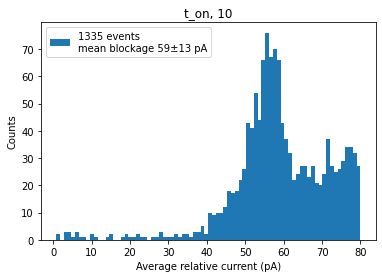

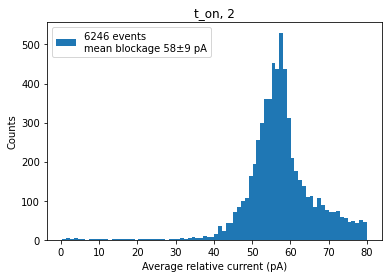

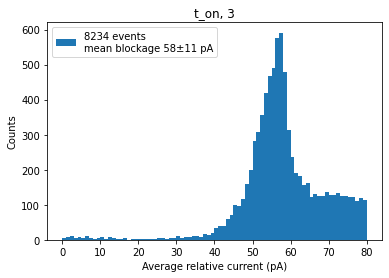

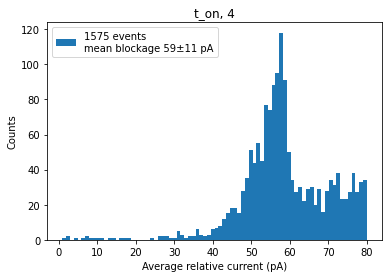

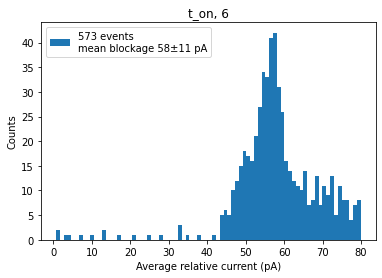

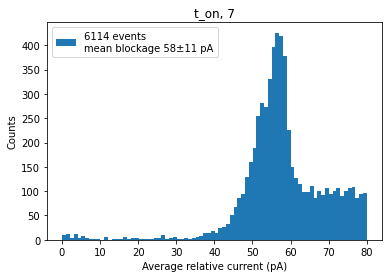

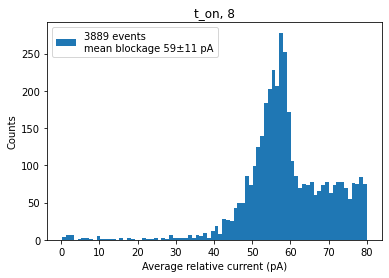

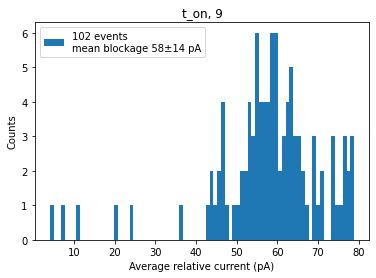

In [4]:
results = []
for pn in key_sels:
    # extract stats
    data = stats_dict[pn][:,0:5].copy() 
    
    current = data[:, 1]
    results.append({'Voltage (mV)':pn})
    results[-1]['mean_current(ms)'] = round(np.mean(current), 2)
    results[-1]['std_current(ms)'] = round(np.std(current), 2)
    
    plt.figure()
    plt.hist(current, bins=lbins_on, density = False, label ="""{} events
mean blockage {}±{} pA""".format(len(current), round(np.mean(current)), round(np.std(current))))
    plt.legend(loc = 'best')
    plt.xlabel('Average relative current (pA)')
    plt.ylabel('Counts')
    plt.title('t_on, {}'.format(pn))
    plt.savefig("graphs/blockage_events{}.png".format(pn), dpi=300)


In [5]:
r = pd.DataFrame(results)
r.to_csv("results/table_{}.csv".format(path), index=False)
r

,Voltage (mV),mean_current(ms),std_current(ms)
0,10,59.18,12.61
1,2,57.58,8.68
2,3,58.10,10.77
3,4,58.90,11.39
4,6,58.05,11.04
5,7,58.26,11.07
6,8,59.28,11.03
7,9,57.71,13.70


In [6]:
print(np.mean(r["mean_current(ms)"]), np.std(r["mean_current(ms)"]))

58.3825 0.6134889974563524


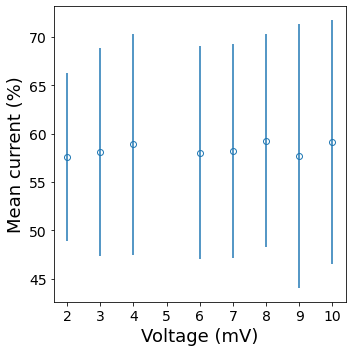

In [7]:
sk = r['Voltage (mV)'].values.astype(int)

plt.figure(figsize =(5,5))
plt.errorbar(sk, r['mean_current(ms)'].values,r['std_current(ms)'].values, label = 'R8', marker = 'o', linestyle = 'none', mfc='none')
plt.ylabel('Mean current (%)', fontsize = fsz)
plt.xlabel('Voltage (mV)'.format(key_sel), fontsize = fsz)
#plt.legend(loc = 'best', fontsize = 0.8*fsz)
#plt.ylim(0,100)
#plt.xlim(-105, -20)
plt.xticks(fontsize = fsz-4)
plt.yticks(fontsize = fsz-4)
plt.tight_layout()
plt.savefig("graphs/graph_{}.png".format(path), dpi=200)
plt.show()